In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the Big Query Library
from google.cloud import bigquery
client = bigquery.Client()

In [3]:
# Number of Unique products for which reviews are available
sql = """
select count(distinct asin) prodCount
from `reviewdata.review_home_kitchen`
"""
reviewedproductCount = client.query(sql).to_dataframe().prodCount[0]
reviewedproductCount

410243

In [4]:
# Number of Unique products for which reviews are available
sql = """
select count(distinct asin) prodCount
from `metadata.meta_Home_Kitchen`
"""
overallproductCount = client.query(sql).to_dataframe().prodCount[0]
overallproductCount

436988

In [5]:
#Products without Reviews
overallproductCount - reviewedproductCount

26745

In [6]:
# Distribution of Ratings in Home&Kitchen category
sql = """
select overall, count(overall) rating
from `reviewdata.review_home_kitchen`
group by overall
order by overall
"""
ratingDistribution = client.query(sql).to_dataframe()

([<matplotlib.axis.XTick at 0x1dac075f7f0>,
 <a list of 5 Text xticklabel objects>)

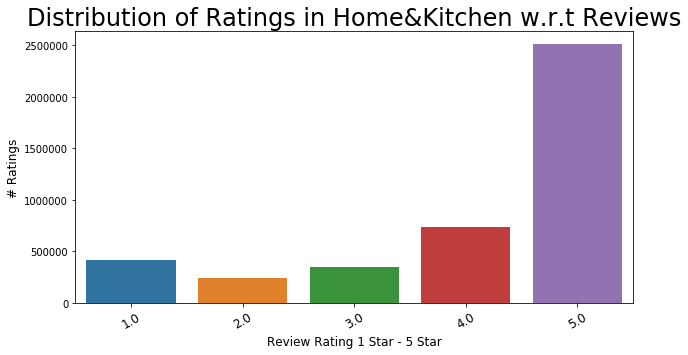

In [7]:
plt.figure(figsize=(10,5))
plt.title("Distribution of Ratings in Home&Kitchen w.r.t Reviews",fontsize=24)
sns.barplot(x = ratingDistribution.overall, y = ratingDistribution.rating)
plt.xlabel('Review Rating 1 Star - 5 Star', fontsize=12)
plt.ylabel('# Ratings', fontsize=12)
index = np.arange(len(ratingDistribution.overall))
plt.xticks(index, round(ratingDistribution.overall,2), fontsize=12, rotation=30)

In [8]:
#Percentage of Rating Distribution
ratingDistribution["% Distribution"] = (ratingDistribution.rating/ratingDistribution.rating.sum())*100
ratingDistribution

,overall,rating,% Distribution
0,1.0,418381,9.835185
1,2.0,242048,5.689998
2,3.0,345093,8.112351
3,4.0,740862,17.415979
4,5.0,2507537,58.946487


In [9]:
#Distribution of Reviews year on year in Home&Kitchen Category
sql = """
select reviewYear, count(reviewYear) Reviews
from `reviewdata.review_home_kitchen`
group by reviewYear
order by reviewYear
"""
reviewDistribution = client.query(sql).to_dataframe()

([<matplotlib.axis.XTick at 0x1dac0bf8ac8>,
 <a list of 15 Text xticklabel objects>)

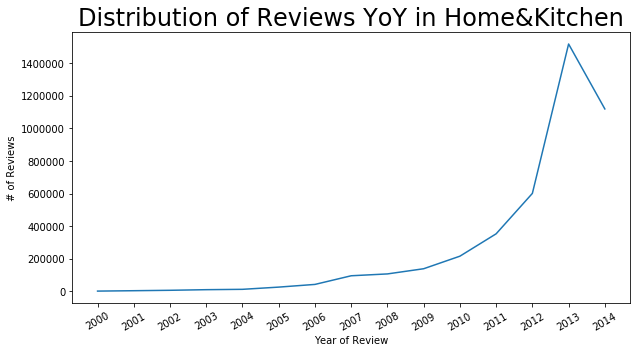

In [10]:
plt.figure(figsize=(10,5))
plt.title("Distribution of Reviews YoY in Home&Kitchen",fontsize=24)
sns.lineplot(data = reviewDistribution.Reviews)
plt.xlabel('Year of Review', fontsize=10)
plt.ylabel('# of Reviews', fontsize=10)
index = np.arange(len(reviewDistribution.reviewYear))
plt.xticks(index, reviewDistribution.reviewYear, fontsize=10, rotation=30)

In [11]:
#No of Products Reviewed every Year in Home&Kitchen Category
sql = """
select reviewYear Year, count(distinct asin) NoofProducts
from `reviewdata.review_home_kitchen`
group by reviewYear
order by reviewYear
"""
yearlyProductDistribution = client.query(sql).to_dataframe()

([<matplotlib.axis.XTick at 0x1dac0cb33c8>,
 <a list of 15 Text xticklabel objects>)

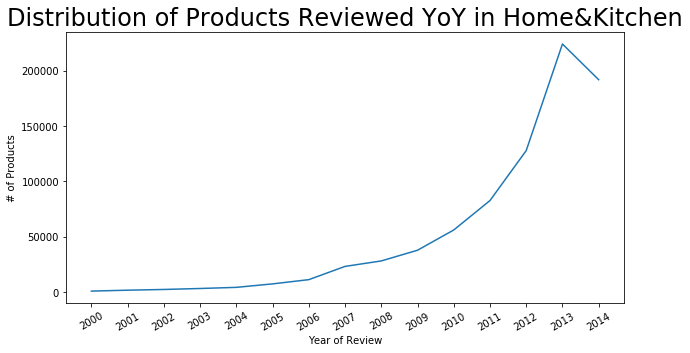

In [12]:
plt.figure(figsize=(10,5))
plt.title("Distribution of Products Reviewed YoY in Home&Kitchen",fontsize=24)
sns.lineplot(data = yearlyProductDistribution.NoofProducts)
plt.xlabel('Year of Review', fontsize=10)
plt.ylabel('# of Products', fontsize=10)
index = np.arange(len(yearlyProductDistribution.Year))
plt.xticks(index, yearlyProductDistribution.Year, fontsize=10, rotation=30)

In [13]:
#No of Products Reviewed since 2011 in Home&Kitchen Category
sql = """
select count(distinct asin) NoofProducts
from `reviewdata.review_home_kitchen`
where reviewYear > 2010
"""
NoofProductsReviewed = client.query(sql).to_dataframe().NoofProducts[0]
NoofProductsReviewed

370898

In [14]:
#Distribution of Products with Number of Reviews in Home&Kitchen category since 2010
sql = """
SELECT COUNT(distinct asin) NoofProducts, bucket 
FROM (
    SELECT asin,CASE WHEN COUNT(reviewText) >=  0 AND COUNT(reviewText) < 20 THEN 1
                        WHEN COUNT(reviewText) >= 20 AND COUNT(reviewText) < 50 THEN 2
                        WHEN COUNT(reviewText) >= 50 AND COUNT(reviewText) < 100 THEN 3
                        WHEN COUNT(reviewText) >= 100 AND COUNT(reviewText) < 300 THEN 4
                        WHEN COUNT(reviewText) >= 300 AND COUNT(reviewText) < 500 THEN 5
                        WHEN COUNT(reviewText) >= 500 THEN 6
                        ELSE 7 END as bucket
    FROM `reviewdata.review_home_kitchen`
    WHERE reviewYear > 2010
    GROUP BY asin) 
GROUP BY bucket
ORDER BY bucket
"""
productReviewsDistribution = client.query(sql).to_dataframe()

In [15]:
productReviewsDistribution['%Distrbution'] = (productReviewsDistribution.NoofProducts
                                              /productReviewsDistribution.NoofProducts.sum())*100 
productReviewsDistribution

,NoofProducts,bucket,%Distrbution
0,340411,1,91.780220
1,17862,2,4.815879
2,6854,3,1.847947
3,4446,4,1.198712
4,762,5,0.205447
5,563,6,0.151794


([<matplotlib.axis.XTick at 0x1dac0c9d278>,
 <a list of 6 Text xticklabel objects>)

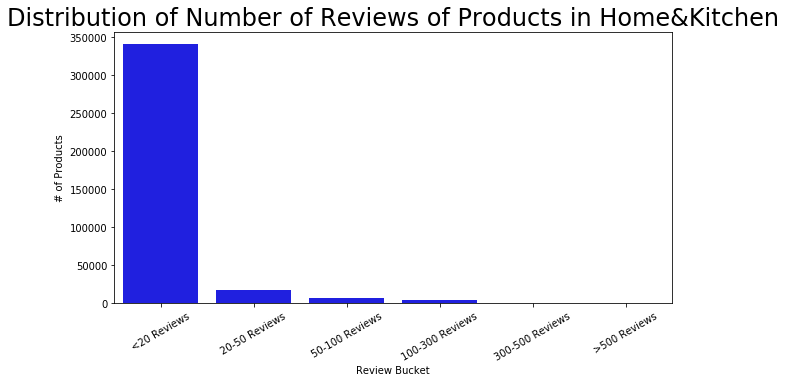

In [16]:
labels = ['<20 Reviews','20-50 Reviews','50-100 Reviews', '100-300 Reviews', '300-500 Reviews', '>500 Reviews']

plt.figure(figsize=(10,5))
plt.title("Distribution of Number of Reviews of Products in Home&Kitchen",fontsize=24)
sns.barplot(x = productReviewsDistribution.bucket, y = productReviewsDistribution.NoofProducts,color='blue')
plt.xlabel('Review Bucket', fontsize=10)
plt.ylabel('# of Products', fontsize=10)
index = np.arange(len(productReviewsDistribution.bucket))
plt.xticks(index, labels, fontsize=10, rotation=30)

In [18]:
#Distribution of Products having more than 100 reviews with Average Rating in Home&Kitchen category
sql = """
SELECT COUNT(distinct asin) NoofProducts, bucket 
FROM (
    SELECT asin, CASE WHEN AVG(Overall) >=  1 AND AVG(Overall) < 2 THEN 1
                        WHEN AVG(Overall) >= 2 AND AVG(Overall) < 4 THEN 2
                        WHEN AVG(Overall) >= 4 AND AVG(Overall) < 6 THEN 3
                        END as bucket
    FROM `reviewdata.review_home_kitchen`
    WHERE reviewYear > 2010
    GROUP BY asin
    HAVING COUNT(reviewText) > 300
) 
GROUP BY bucket
ORDER BY bucket
"""
productRatingsDistribution = client.query(sql).to_dataframe()
productRatingsDistribution

,NoofProducts,bucket
0,1,1
1,388,2
2,931,3


([<matplotlib.axis.XTick at 0x1dac0d7b240>,
 <a list of 3 Text xticklabel objects>)

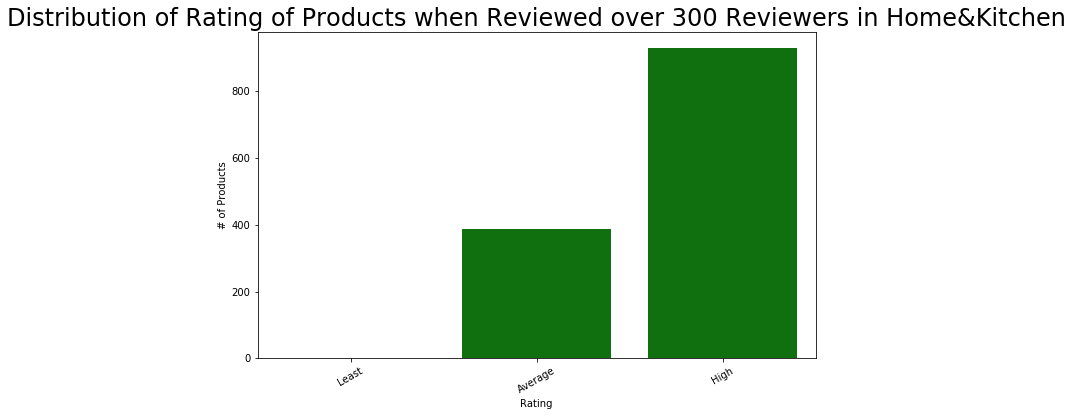

In [19]:
labels = ['Least','Average','High']
colors = ['red','blue','green']

plt.figure(figsize=(10,6))
plt.title("Distribution of Rating of Products when Reviewed over 300 Reviewers in Home&Kitchen",fontsize=24)
sns.barplot(x = productRatingsDistribution.bucket, y = productRatingsDistribution.NoofProducts,color='green')
plt.xlabel('Rating', fontsize=10)
plt.ylabel('# of Products', fontsize=10)
index = np.arange(len(productRatingsDistribution.bucket))
plt.xticks(index, labels, fontsize=10, rotation=30)

In [20]:
#No of Top Reviewed Products in Home&Kitchen since 2011
sql = """
SELECT
  ReviewYear,
  COUNT(distinct ProductID) NoofProducts
FROM (
  SELECT
    reviewYear ReviewYear,
    asin ProductID,
    COUNT(reviewText) AS NumberofReviews,
    ROUND(AVG(overall),2) AvgRating
  FROM
    `reviewdata.review_home_kitchen`
  WHERE
    reviewYear > 2010
  GROUP BY
    1,2
  HAVING COUNT(reviewText) > 100
    )
GROUP BY
    ReviewYear
ORDER BY
  ReviewYear
"""
topReviewedProductsCount = client.query(sql).to_dataframe()

([<matplotlib.axis.XTick at 0x1dac10578d0>,
 <a list of 4 Text xticklabel objects>)

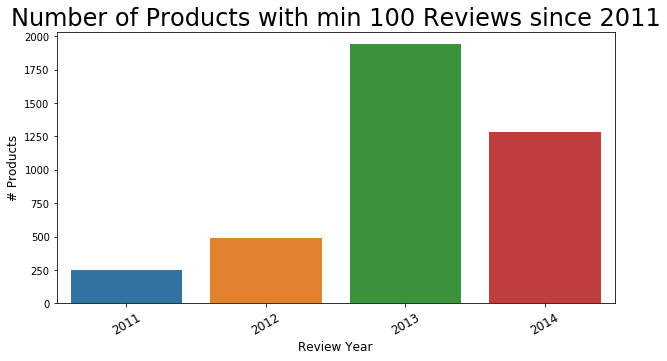

In [21]:
plt.figure(figsize=(10,5))
plt.title("Number of Products with min 100 Reviews since 2011",fontsize=24)
sns.barplot(x = topReviewedProductsCount.ReviewYear, y = topReviewedProductsCount.NoofProducts)
plt.xlabel('Review Year', fontsize=12)
plt.ylabel('# Products', fontsize=12)
index = np.arange(len(topReviewedProductsCount.ReviewYear))
plt.xticks(index, topReviewedProductsCount.ReviewYear, fontsize=12, rotation=30)

In [22]:
#Top 5 Reviewed Products every Year in Home&Kitchen since 2011
sql = """
SELECT
  ReviewYear,
  ProductID,
  NumberofReviews,
  AvgRating
FROM (
  SELECT
    reviewYear ReviewYear,
    asin ProductID,
    COUNT(reviewText) AS NumberofReviews,
    ROUND(AVG(overall),2) AvgRating,
    ROW_NUMBER() OVER (PARTITION BY reviewYear  ORDER BY COUNT(reviewText) DESC) AS ProductRank
  FROM
    `reviewdata.review_home_kitchen`
  WHERE
    reviewYear > 2010
  GROUP BY
    1,2
    )
WHERE
  ProductRank <= 5
ORDER BY
  ReviewYear ,
  ProductRank
"""
topReviewedProducts = client.query(sql).to_dataframe()
topReviewedProducts

,ReviewYear,ProductID,NumberofReviews,AvgRating
0,2011,B001N07KUE,1284,4.80
1,2011,B00005IBX9,761,3.63
2,2011,B001LYFBHG,601,3.50
3,2011,B00009R66F,576,4.21
4,2011,B002MK6QKO,535,4.69
5,2012,B001N07KUE,1398,4.79
6,2012,B0047E0EII,1201,3.76
7,2012,B0006HUYGM,835,4.43
8,2012,B00009R66F,696,4.07
9,2012,B002HFDLCK,692,3.84


In [23]:
#Top 10 5 Rated Products with its reviews
sql = """
select asin ProductID, title ProductName, price Price, count(reviewText) NumberReviews, ROUND(AVG(overall),2) AvgRating
from `reviewdata.review_home_kitchen`
group by asin,title,price
order by AVG(overall) desc,count(reviewText) desc
limit 10
"""
topRatedProducts = client.query(sql).to_dataframe()

#Top 10 5 Rated Products with its reviews
topRatedProducts

,ProductID,ProductName,Price,NumberReviews,AvgRating
0,B002YX0HMC,Rubbermaid White Ice Cube Tray (Pack of 6),18.95,57,5.0
1,B00G2WME1S,"Coffee Mug Designed by Ron Howard, Dragon Fish...",24.13,49,5.0
2,B005RK8JF6,Pastry Board- Kneading Board-Cutting Board PBB...,81.31,42,5.0
3,B00HQCJP88,3 Silicone Coated Fiberglass Baking Mats - SET...,23.70,42,5.0
4,B00J8WTTH6,Mason Jar Shot Glasses by The Slinger | 5-Pack...,14.99,36,5.0
5,B00H0T5GXK,Silicone Baking Mat - #1 Best Seller - This La...,13.99,36,5.0
6,B009AN37V2,"Moon Calendar 2013, LunarPhases, MoonLight",12.95,34,5.0
7,B00C2UF92K,"Charles Viancin 13-Inch Lilypad Silicone Lid, ...",12.95,34,5.0
8,B000RHYFD4,Global G-48338 - 3 Piece Knife Set with Santok...,184.19,33,5.0
9,B0047ZG5QC,Omnisax Bloom Pouch Set,41.99,32,5.0


In [24]:
#Top Reviewed Products in overall Home&Kitchen category across Years
sql = """
select asin ProductID, title ProductName, price Price, count(reviewText) NumberofReviews, ROUND(AVG(overall),2) AvgRating
from `reviewdata.review_home_kitchen`
group by asin,title,price
order by count(reviewText) desc,AVG(overall) desc
limit 10
"""
topReviewRatedProducts = client.query(sql).to_dataframe()

# Products with all time highest reviews and corresponding ratings
topReviewRatedProducts

,ProductID,ProductName,Price,NumberofReviews,AvgRating
0,B001N07KUE,"EatSmart Precision Pro Digital Kitchen Scale, ...",29.50,6690,4.74
1,B000QFDNP8,Contigo AUTOSEAL Stainless Steel Vacuum Insula...,22.48,5049,4.41
2,B00009R66F,Hoover SteamVac Carpet Cleaner with Clean Surg...,154.68,5011,4.23
3,B0047E0EII,Hutzler 571 Banana Slicer,1.97,4888,3.74
4,B00005IBX9,Cuisinart DCC-1200 Brew Central 12-Cup Program...,76.42,4614,3.85
5,B0006HUYGM,"Eureka EasyClean Corded Hand-Held Vacuum, 71B",39.99,4094,4.43
6,B00006JSUA,"Lodge L8SK3 Pre-Seasoned Cast-Iron Skillet, 10...",15.92,3838,4.58
7,B00006IUWA,"Presto 04820 PopLite Hot Air Popper, White",19.85,3830,4.29
8,B002HFDLCK,Hoover WindTunnel T-Series Rewind Plus Bagless...,117.99,3779,3.85
9,B00065L6CU,Hamilton Beach 51101 Personal Blender with Tra...,10.96,3611,3.97


In [25]:
# 20 Least Rated Product with More Reviews in Home&Kitchen
sql = """
select asin ProductID, title ProductName, price Price, count(reviewText) NumberofReviews, ROUND(AVG(overall),2) AvgRating
from `reviewdata.review_home_kitchen`
where reviewYear > 2010
group by asin,title,price
having (AVG(overall) BETWEEN 1 AND 2 AND count(reviewText) > 50)
order by  count(reviewText) desc,AVG(overall) desc
limit 20
"""
leastReviewRatedProducts = client.query(sql).to_dataframe()
leastReviewRatedProducts.head(10)

,ProductID,ProductName,Price,NumberofReviews,AvgRating
0,B005BY5I2K,Eggies Hard Boiled Egg System,5.00,441,1.66
1,B002VED30M,HealthMaster LWHM Living Well/Montel 1100-Watt...,158.95,228,1.96
2,B00028I1M4,Dryer Vent Vacuum Cleaner Attachment,10.99,160,1.84
3,B00266X5IA,Full Body Bathtub Lounger,8.28,152,1.82
4,B00302122U,Elite Series II Digital Bathroom Scale with 5&...,NaN,137,1.96
5,B005FSRF6E,OneTouch Can Opener,NaN,132,1.58
6,B00006IV0N,"Brita Space Saver Water Filter Pitcher, White,...",20.19,127,1.69
7,B0058CLNBU,None,29.16,115,1.81
8,B0099KRUSC,Multifunction Vegetable Fruit Twister Cutter S...,4.88,115,1.59
9,B000BFWFJ8,4 BED Sheet Grippers Garters Bedding Straps Su...,1.85,113,1.82


In [26]:
#Distribution of Reviews Length in Home&Kitchen category
sql = """
SELECT COUNT(reviewText) no_reviews, bucket 
FROM (
    SELECT reviewText, CASE WHEN CHAR_LENGTH(reviewText) >=  0 AND CHAR_LENGTH(reviewText) < 100 THEN 1
                        WHEN CHAR_LENGTH(reviewText) >= 100 AND CHAR_LENGTH(reviewText) < 200 THEN 2
                        WHEN CHAR_LENGTH(reviewText) >= 200 AND CHAR_LENGTH(reviewText) < 300 THEN 3
                        WHEN CHAR_LENGTH(reviewText) >= 300 AND CHAR_LENGTH(reviewText) < 400 THEN 4
                        WHEN CHAR_LENGTH(reviewText) >= 400 AND CHAR_LENGTH(reviewText) < 500 THEN 5
                        WHEN CHAR_LENGTH(reviewText) >= 500 AND CHAR_LENGTH(reviewText) < 600 THEN 6
                        WHEN CHAR_LENGTH(reviewText) >= 600 AND CHAR_LENGTH(reviewText) < 700 THEN 7
                        WHEN CHAR_LENGTH(reviewText) >= 700 AND CHAR_LENGTH(reviewText) < 800 THEN 8
                        WHEN CHAR_LENGTH(reviewText) >= 800 AND CHAR_LENGTH(reviewText) < 900 THEN 9
                        WHEN CHAR_LENGTH(reviewText) >= 900 AND CHAR_LENGTH(reviewText) < 1000 THEN 10
                        ELSE 11 END as bucket
    FROM `reviewdata.review_home_kitchen`) 
GROUP BY bucket
ORDER BY bucket
"""
reviewLengthDistribution = client.query(sql).to_dataframe()

([<matplotlib.axis.XTick at 0x1dac0f365c0>,
 <a list of 11 Text xticklabel objects>)

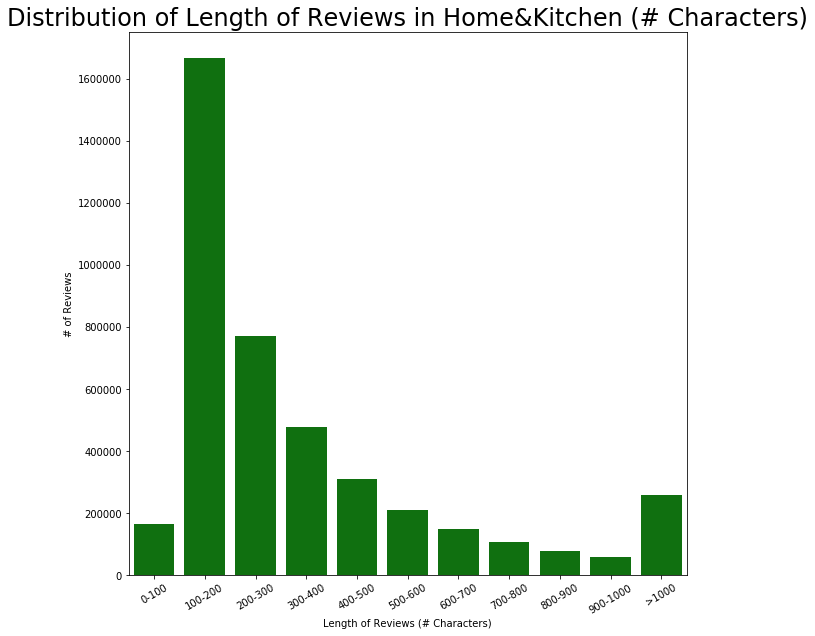

In [27]:
labels = ['0-100','100-200','200-300','300-400','400-500','500-600','600-700','700-800','800-900','900-1000','>1000']

plt.figure(figsize=(10,10))
plt.title("Distribution of Length of Reviews in Home&Kitchen (# Characters)",fontsize=24)
sns.barplot(x = reviewLengthDistribution.bucket, y = reviewLengthDistribution.no_reviews,color='green')
plt.xlabel('Length of Reviews (# Characters)', fontsize=10)
plt.ylabel('# of Reviews', fontsize=10)
index = np.arange(len(reviewLengthDistribution.bucket))
plt.xticks(index, labels, fontsize=10, rotation=30)

In [28]:
#Average Reviews Length in Home&Kitchen
sql = """
SELECT AVG(CHAR_LENGTH(reviewText)) AvgReviewLength
FROM `reviewdata.review_home_kitchen`
"""
AvgReviewLength = client.query(sql).to_dataframe().AvgReviewLength[0]
AvgReviewLength

373.8058379551482

In [29]:
#Min , Max and Average Price of Products in Home&Kitchen
sql = """
SELECT MIN(price) MinPrice, MAX(price) MaxPrice, AVG(Price) AvgPrice
FROM `reviewdata.review_home_kitchen`
WHERE price > 0
"""
priceInfo = client.query(sql).to_dataframe()
priceInfo

,MinPrice,MaxPrice,AvgPrice
0,0.01,999.99,57.167473


In [30]:
# Number of distinct Products with Price Information
sql = """
SELECT count(distinct asin) productwithPrice
FROM `reviewdata.review_home_kitchen`
WHERE price > 0 AND reviewYear > 2010
"""
productwithPrice = client.query(sql).to_dataframe().productwithPrice[0]
productwithPrice

256593

In [31]:
#Distribution of Price Bucket in Home&Kitchen
sql = """
SELECT COUNT(distinct asin) no_products, bucket 
FROM (
    SELECT  asin, CASE WHEN price >=  0 AND price < 10 THEN 1
                        WHEN price >= 10 AND price < 20 THEN 2
                        WHEN price >= 20 AND price < 30 THEN 3
                        WHEN price >= 30 AND price < 50 THEN 4
                        WHEN price >= 50 AND price < 100 THEN 5
                        WHEN price >= 100 AND price < 150 THEN 6
                        WHEN price >= 150 AND price < 200 THEN 7
                        WHEN price >= 200 AND price < 300 THEN 8
                        WHEN price >= 300 THEN 9
                        END as bucket
    FROM `reviewdata.review_home_kitchen`
    WHERE reviewYear > 2010) 
GROUP BY bucket
ORDER BY bucket
"""
priceDistribution = client.query(sql).to_dataframe()

([<matplotlib.axis.XTick at 0x1dac0fe9208>,
 <a list of 9 Text xticklabel objects>)

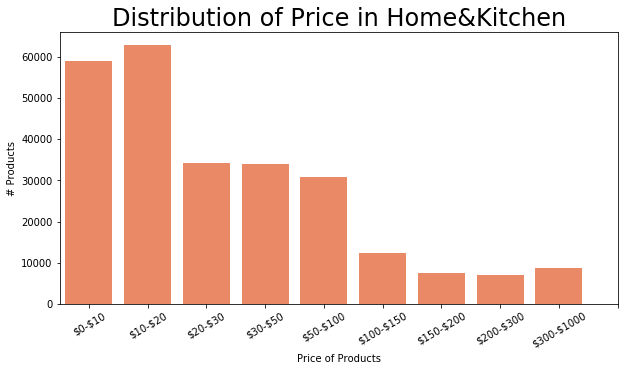

In [32]:
labels = ['\$0-\$10','\$10-\$20','\$20-\$30','\$30-\$50','\$50-\$100','\$100-\$150',
          '\$150-\$200','\$200-\$300','\$300-\$1000']

plt.figure(figsize=(10,5))
plt.title("Distribution of Price in Home&Kitchen",fontsize=24)
sns.barplot(x = priceDistribution.bucket, y = priceDistribution.no_products, color='coral')
plt.xlabel('Price of Products', fontsize=10)
plt.ylabel('# Products', fontsize=10)
index = np.arange(len(priceDistribution.bucket))
plt.xticks(index, labels, fontsize=10, rotation=30)

In [33]:
#Percentage of Price Distribution
priceDistribution_d = priceDistribution[1:11]
priceDistribution_d["% Distribution"] = (priceDistribution_d.no_products/priceDistribution_d.no_products.sum())*100
priceDistribution_d

,no_products,bucket,% Distribution
1,59067,1.0,23.019724
2,62936,2.0,24.527559
3,34275,3.0,13.357730
4,34039,4.0,13.265755
5,30768,5.0,11.990974
6,12252,6.0,4.774877
7,7393,7.0,2.881217
8,7044,8.0,2.745203
9,8819,9.0,3.436960


In [35]:
# Number of distinct Products with Price Information
sql = """
SELECT count(distinct asin) productwithPrice100
FROM ( select asin , COUNT(reviewText)
FROM `reviewdata.review_home_kitchen`
WHERE price > 0 AND reviewYear > 2010 
group by asin
having COUNT(reviewText) > 50
)
"""
productwithPrice100 = client.query(sql).to_dataframe().productwithPrice100[0]
productwithPrice100

11649

In [37]:
#Distribution of Price Bucket with Products having more than 100 reviews in Home&Kitchen
sql = """
SELECT COUNT(distinct asin) NoofProducts, bucket PriceBucket
FROM (
    SELECT  asin, CASE WHEN price >=  0 AND price < 10 THEN 1
                        WHEN price >= 10 AND price < 20 THEN 2
                        WHEN price >= 20 AND price < 30 THEN 3
                        WHEN price >= 30 AND price < 50 THEN 4
                        WHEN price >= 50 AND price < 100 THEN 5
                        WHEN price >= 100 AND price < 150 THEN 6
                        WHEN price >= 150 AND price < 200 THEN 7
                        WHEN price >= 200 AND price < 300 THEN 8
                        WHEN price >= 300 THEN 9
                        END as bucket
    FROM (  SELECT asin, price
            FROM `reviewdata.review_home_kitchen`
            WHERE reviewYear > 2010 AND price > 0
            GROUP BY asin,price
            HAVING COUNT(reviewText) > 50)
    ) 
GROUP BY bucket
ORDER BY bucket
"""
priceDistribution100 = client.query(sql).to_dataframe()
priceDistribution100

,NoofProducts,PriceBucket
0,2317,1
1,2873,2
2,1710,3
3,1645,4
4,1574,5
5,579,6
6,387,7
7,300,8
8,264,9


In [38]:
#Relation of Price of product with the Average Rating of the product
sql = """
SELECT asin ProductID, price Price, bucket PriceBucket, count(reviewText) NumberReviews, 
       ROUND(AVG(overall),2) AvgRating, ROUND(AVG(CHAR_LENGTH(reviewText)),2) ReviewLength 
FROM (
    SELECT  asin,price, reviewText,overall, CASE WHEN price >=  0 AND price < 10 THEN 1
                        WHEN price >= 10 AND price < 20 THEN 2
                        WHEN price >= 20 AND price < 30 THEN 3
                        WHEN price >= 30 AND price < 50 THEN 4
                        WHEN price >= 50 AND price < 100 THEN 5
                        WHEN price >= 100 AND price < 150 THEN 6
                        WHEN price >= 150 AND price < 200 THEN 7
                        WHEN price >= 200 AND price < 300 THEN 8
                        WHEN price >= 300 THEN 9
                        END as bucket
    FROM `reviewdata.review_home_kitchen`
    WHERE reviewYear > 2010 AND price > 0) 
GROUP BY asin,price,bucket
HAVING COUNT(reviewText)> 50
ORDER BY AVG(overall) desc,count(reviewText) desc,bucket
"""
ratingPriceDistribution = client.query(sql).to_dataframe()

Text(0, 0.5, 'Price of Product (\\$)')

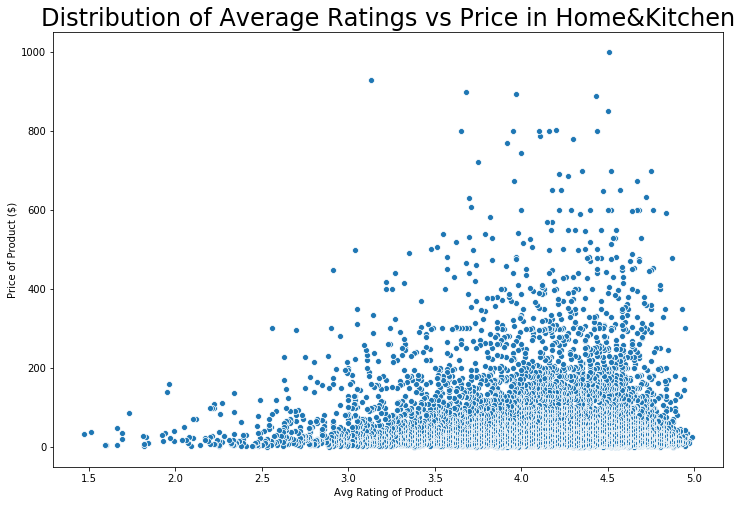

In [39]:
plt.figure(figsize=(12,8))
plt.title("Distribution of Average Ratings vs Price in Home&Kitchen",fontsize=24)
sns.scatterplot(x=ratingPriceDistribution['AvgRating'], y=ratingPriceDistribution['Price'])
plt.xlabel('Avg Rating of Product', fontsize=10)
plt.ylabel('Price of Product (\$)', fontsize=10)

Text(0, 0.5, 'Review Length of Product')

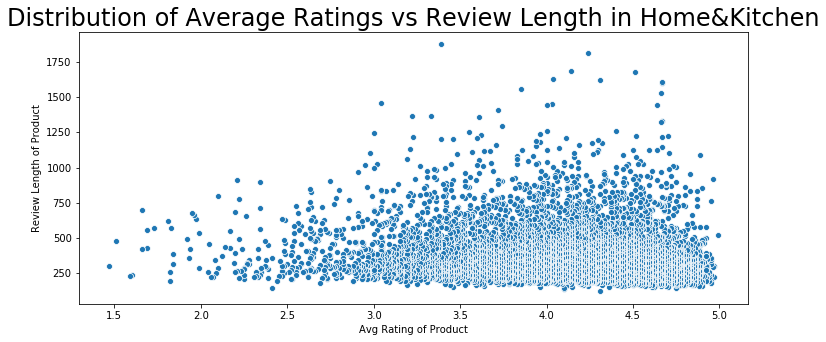

In [40]:
plt.figure(figsize=(12,5))
plt.title("Distribution of Average Ratings vs Review Length in Home&Kitchen",fontsize=24)
sns.scatterplot(x=ratingPriceDistribution['AvgRating'], y=ratingPriceDistribution['ReviewLength'])
plt.xlabel('Avg Rating of Product', fontsize=10)
plt.ylabel('Review Length of Product', fontsize=10)

In [41]:
# Remove reviews with length greater than 3000 characters
ratingPriceDistributionProcessed = ratingPriceDistribution[ratingPriceDistribution <=3000]

Text(0.5, 0, 'Price of Product (\\$)')

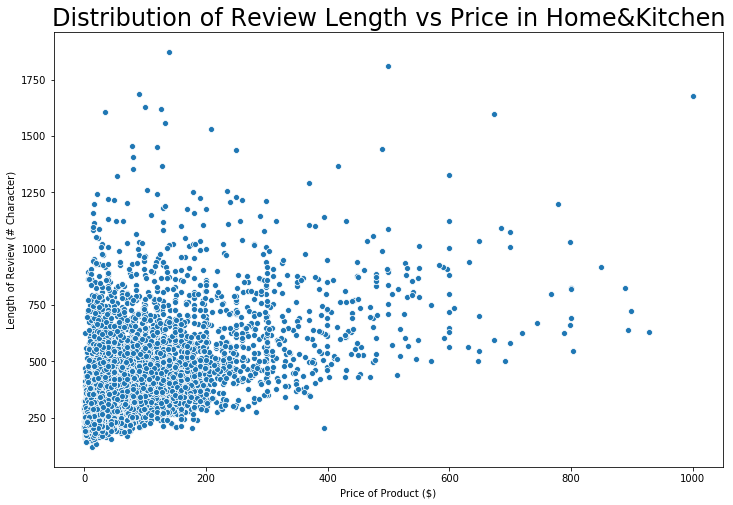

In [42]:
plt.figure(figsize=(12,8))
plt.title("Distribution of Review Length vs Price in Home&Kitchen",fontsize=24)
sns.scatterplot(x=ratingPriceDistributionProcessed['Price'], y=ratingPriceDistributionProcessed['ReviewLength'])
plt.ylabel('Length of Review (# Character)', fontsize=10)
plt.xlabel('Price of Product (\$)', fontsize=10)

Text(0, 0.5, '# Reviews')

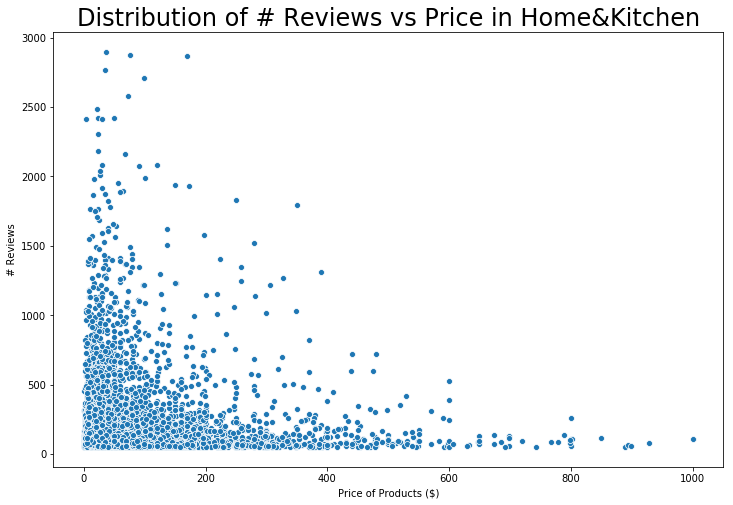

In [43]:
plt.figure(figsize=(12,8))
plt.title("Distribution of # Reviews vs Price in Home&Kitchen",fontsize=24)
sns.scatterplot(x=ratingPriceDistributionProcessed['Price'], y=ratingPriceDistributionProcessed['NumberReviews'])
plt.xlabel('Price of Products (\$)', fontsize=10)
plt.ylabel('# Reviews', fontsize=10)

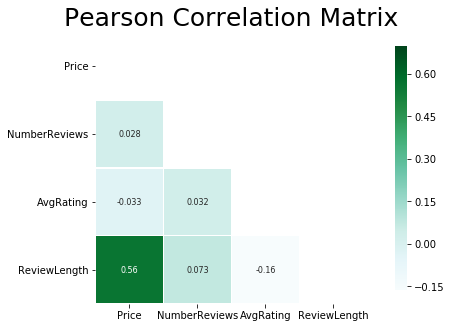

In [44]:
# Plot the Pearson Correlation Matrix for each of the variables

x_cols = [col for col in ratingPriceDistributionProcessed.columns if col not in ['ProductID','PriceBucket']]
mask = np.zeros_like(ratingPriceDistributionProcessed[x_cols].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(10, 5))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(ratingPriceDistributionProcessed[x_cols].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

In [54]:
#Split of Price Buckets with its associated metrics
sql = """
SELECT bucket PriceBucket, COUNT(distinct asin) ProductID, count(reviewText) NumberReviews, 
       ROUND(AVG(overall),2) AvgRating, ROUND(AVG(CHAR_LENGTH(reviewText)),2) ReviewLength 
FROM (
    SELECT  asin,price, reviewText,overall, CASE WHEN price >=  0 AND price < 10 THEN 1
                        WHEN price >= 10 AND price < 20 THEN 2
                        WHEN price >= 20 AND price < 30 THEN 3
                        WHEN price >= 30 AND price < 50 THEN 4
                        WHEN price >= 50 AND price < 100 THEN 5
                        WHEN price >= 100 AND price < 150 THEN 6
                        WHEN price >= 150 AND price < 200 THEN 7
                        WHEN price >= 200 AND price < 300 THEN 8
                        WHEN price >= 300 THEN 9
                        END as bucket
    FROM `reviewdata.review_home_kitchen`
    WHERE reviewYear > 2010) 
GROUP BY bucket
ORDER BY bucket,AVG(overall) desc,count(reviewText) desc
"""
ratingPriceDistribution1 = client.query(sql).to_dataframe()

In [55]:
ratingPriceDistribution1['AvgReviews'] = round(ratingPriceDistribution1['NumberReviews']
                                               /ratingPriceDistribution1['ProductID'],0)

In [56]:
ratingPriceDistribution1[1:10]

,PriceBucket,ProductID,NumberReviews,AvgRating,ReviewLength,AvgReviews
1,1.0,96435,1527459,4.00,284.78,16.0
2,2.0,81168,1228586,4.06,329.96,15.0
3,3.0,42358,695442,4.07,386.37,16.0
4,4.0,42625,790236,4.03,429.35,19.0
5,5.0,39642,788194,4.00,494.20,20.0
6,6.0,15130,347465,4.00,559.39,23.0
7,7.0,9576,256727,4.11,550.29,27.0
8,8.0,9466,226036,4.10,619.97,24.0
9,9.0,15251,297333,4.11,718.08,19.0


In [57]:
#Number of distinct Products in Home&Kitchen
sql = """
SELECT COUNT(distinct asin) no_products 
FROM `reviewdata.review_home_kitchen`
"""
client.query(sql).to_dataframe().no_products[0]

475976

In [59]:
#Distribution of Ratings of Products in Home&Kitchen
sql = """
SELECT COUNT(distinct asin) NoofProducts, bucket RatingBucket
FROM (
    SELECT  asin, CASE WHEN avg(overall) >=  0 AND avg(overall) < 1 THEN 1
                        WHEN avg(overall) >= 1 AND avg(overall) < 2 THEN 2
                        WHEN avg(overall) >= 2 AND avg(overall) < 3 THEN 3
                        WHEN avg(overall) >= 3 AND avg(overall) < 4 THEN 4
                        WHEN avg(overall) >= 4 AND avg(overall) < 5 THEN 5
                        WHEN avg(overall) = 5 THEN 6
                        END as bucket
    FROM `reviewdata.review_home_kitchen`
    group by asin) 
GROUP BY bucket
ORDER BY bucket
"""
productRatingDistribution = client.query(sql).to_dataframe()
productRatingDistribution

,NoofProducts,RatingBucket
0,33508,2
1,40832,3
2,110032,4
3,160237,5
4,131367,6


([<matplotlib.axis.XTick at 0x1b8d823b828>,
 <a list of 5 Text xticklabel objects>)

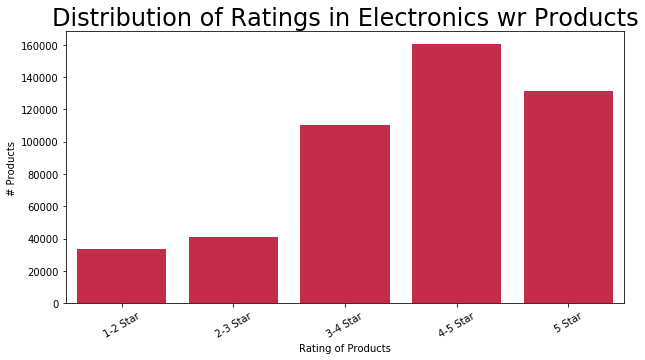

In [62]:
labels = ['1-2 Star','2-3 Star','3-4 Star','4-5 Star','5 Star']

plt.figure(figsize=(10,5))
plt.title("Distribution of Ratings in Home&Kitchen wr Products",fontsize=24)
sns.barplot(x = productRatingDistribution.RatingBucket, y = productRatingDistribution.NoofProducts,color='crimson')
plt.xlabel('Rating of Products', fontsize=10)
plt.ylabel('# Products', fontsize=10)
index = np.arange(len(productRatingDistribution.RatingBucket))
plt.xticks(index, labels, fontsize=10, rotation=30)

In [63]:
# Analysis of Reviewers Behavior
sql = """
select reviewerID, count(reviewText) NumberReviews, 
       ROUND(AVG(overall),2) AvgRating, ROUND(AVG(CHAR_LENGTH(reviewText)),2) ReviewLength
from `reviewdata.review_home_kitchen`
group by reviewerID
order by count(reviewText) desc
"""
reviewerDistribution = client.query(sql).to_dataframe()

In [64]:
# Number of Reviewers in Home&Kitchen
len(reviewerDistribution.reviewerID.unique())

4200844

In [65]:
reviewerDistribution.head(10)

,reviewerID,NumberReviews,AvgRating,ReviewLength
0,A5JLAU2ARJ0BO,520,3.86,1453.87
1,ADLVFFE4VBT8,501,4.28,2656.50
2,A3OXHLG6DIBRW8,498,4.45,968.56
3,A6FIAB28IS79,431,4.18,2274.83
4,A680RUE1FDO8B,406,4.41,1781.24
5,A1ODOGXEYECQQ8,380,4.31,1116.33
6,A36K2N527TXXJN,314,4.53,2097.19
7,A2AY4YUOX2N1BQ,311,4.56,1854.41
8,AWPODHOB4GFWL,308,4.39,1377.35
9,A25C2M3QF9G7OQ,296,4.63,1731.98


In [66]:
# Remove records with reviews > 50
reviewDistDum = reviewerDistribution[reviewerDistribution['NumberReviews'] < 50]

Text(0, 0.5, '# Reviewers')

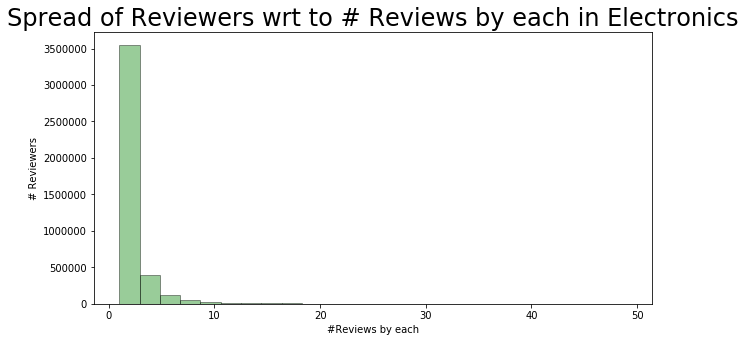

In [67]:
plt.figure(figsize=(10,5))
plt.title("Spread of Reviewers wrt to # Reviews by each in Home&Kitchen",fontsize=24)
sns.distplot(reviewDistDum['NumberReviews'], hist=True, kde=False, 
             bins=int(25), color = 'green',
             hist_kws={'edgecolor':'black'})
plt.xlabel('#Reviews by each', fontsize=10)
plt.ylabel('# Reviewers', fontsize=10)

Text(0, 0.5, '# Reviewers')

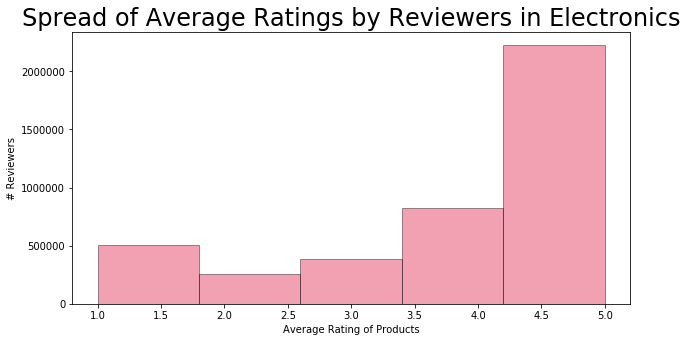

In [68]:
plt.figure(figsize=(10,5))
plt.title("Spread of Average Ratings by Reviewers in Home&Kitchen",fontsize=24)
sns.distplot(reviewerDistribution['AvgRating'], hist=True, kde=False, 
             bins=int(5), color = 'crimson',
             hist_kws={'edgecolor':'black'})
plt.xlabel('Average Rating of Products', fontsize=10)
plt.ylabel('# Reviewers', fontsize=10)

In [69]:
#Remove reviewers with Reviews < 5
ratingAnalysis = reviewerDistribution[reviewerDistribution.NumberReviews > 5]

Text(0, 0.5, '# Reviewers')

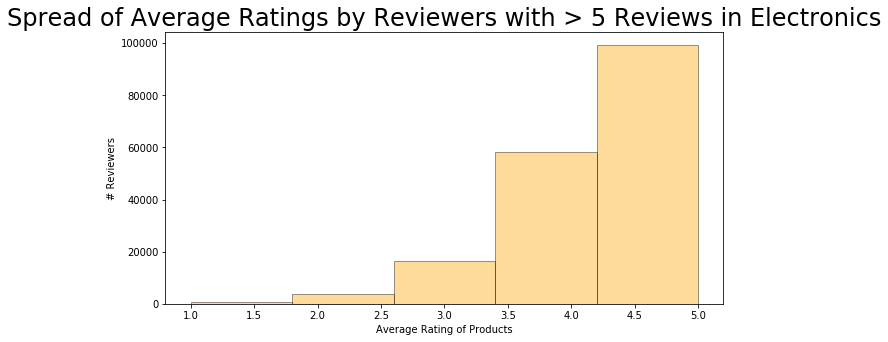

In [70]:
plt.figure(figsize=(10,5))
plt.title("Spread of Average Ratings by Reviewers with > 5 Reviews in Home&Kitchen",fontsize=24)
sns.distplot(ratingAnalysis['AvgRating'], hist=True, kde=False, 
             bins=int(5), color = 'orange',
             hist_kws={'edgecolor':'black'})
plt.xlabel('Average Rating of Products', fontsize=10)
plt.ylabel('# Reviewers', fontsize=10)

In [72]:
# number of Reviewers who wrote more than 5 Reviews
len(ratingAnalysis.reviewerID.unique())/len(reviewerDistribution.reviewerID.unique())*100

4.252788249218491

In [73]:
# Number of Reviewers on an average per Product
sql = """
SELECT ROUND(AVG(NoofReviewers),0) AverageNoofReviewers
from (
select asin ProductID, COUNT(reviewerID) NoofReviewers
from `reviewdata.review_home_kitchen`
group by asin
)
"""
AverageNoofReviewers = client.query(sql).to_dataframe().AverageNoofReviewers[0]
AverageNoofReviewers

16.0

In [92]:
# Top 10 Reviewers with their Split of Rating
sql = """
select reviewerID Customer , 
count(*) NoofReviews, 
Round(avg(overall),2) AvgRating, 
AVG(CHAR_LENGTH(reviewText)) AvgReviewLength,
sum(case when overall = 1 then 1 else 0 end) OneStar, 
sum(case when overall = 2 then 1 else 0 end) TwoStar, 
sum(case when overall = 3 then 1 else 0 end) ThreeStar, 
sum(case when overall = 4 then 1 else 0 end) FourStar, 
sum(case when overall = 5 then 1 else 0 end) FiveStar 
from `reviewdata.review_home_kitchen`  
group by 1 
order by 2 desc 
limit 10
"""
TopReviewersSplit = client.query(sql).to_dataframe()
TopReviewersSplit

,Customer,NoofReviews,AvgRating,AvgReviewLength,OneStar,TwoStar,ThreeStar,FourStar,FiveStar
0,A5JLAU2ARJ0BO,520,3.86,1453.865385,67,51,44,83,275
1,ADLVFFE4VBT8,501,4.28,2656.502994,9,24,54,143,271
2,A3OXHLG6DIBRW8,498,4.45,968.558233,2,7,25,194,270
3,A6FIAB28IS79,431,4.18,2274.825986,7,28,56,128,212
4,A680RUE1FDO8B,406,4.41,1781.236453,21,15,38,36,296
5,A1ODOGXEYECQQ8,380,4.31,1116.334211,0,10,24,186,160
6,A36K2N527TXXJN,314,4.53,2097.187898,1,2,11,117,183
7,A2AY4YUOX2N1BQ,311,4.56,1854.408360,1,2,18,91,199
8,AWPODHOB4GFWL,308,4.39,1377.353896,7,7,29,80,185
9,ARBKYIVNYWK3C,296,4.44,981.111486,2,3,29,92,170


In [93]:
# Top 25 Reviewers with their Split of Brand
sql = """
select reviewerID Customer, brand Brand, count(Brand) NoofReviews
FROM `reviewdata.review_home_kitchen`
WHERE reviewerID in (
  select reviewerID Customer 
  from `reviewdata.review_home_kitchen`  
  group by 1
  order by COUNT(reviewText) desc 
limit 25)
group by reviewerID, brand
order by reviewerID,count(Brand) DESC
"""
TopReviewersBrandSplit = client.query(sql).to_dataframe()
TopReviewersBrandSplit.head()

,Customer,Brand,NoofReviews
0,A12DQZKRKTNF5E,ARCTIC,7
1,A12DQZKRKTNF5E,Logitech,7
2,A12DQZKRKTNF5E,HP,6
3,A12DQZKRKTNF5E,Sony,5
4,A12DQZKRKTNF5E,Sabrent,4


In [94]:
# Top 10 Reviewers with their top 2 favourite brands
sql = """
SELECT
  Customer,
  Brand,
  NoofReviews
FROM (select reviewerID Customer, 
             brand Brand, 
             count(Brand) NoofReviews,
             RANK() OVER (PARTITION BY reviewerID ORDER BY COUNT(Brand) DESC) AS BrandRank
FROM `reviewdata.review_home_kitchen`
WHERE reviewerID in (
  select reviewerID Customer 
  from `reviewdata.review_home_kitchen`  
  group by 1
  order by COUNT(reviewText) desc 
limit 25)
group by reviewerID, brand
order by reviewerID, BrandRank ASC)
WHERE
  BrandRank <= 2
ORDER BY
  Customer ,
  NoofReviews DESC
"""
TopReviewersTopBrandSplit = client.query(sql).to_dataframe()
TopReviewersTopBrandSplit.head(10)

,Customer,Brand,NoofReviews
0,A12DQZKRKTNF5E,ARCTIC,7
1,A12DQZKRKTNF5E,Logitech,7
2,A17BUUBOU0598B,BELKIN,11
3,A17BUUBOU0598B,Logitech,10
4,A1ODOGXEYECQQ8,BELKIN,8
5,A1ODOGXEYECQQ8,Canon,6
6,A1ODOGXEYECQQ8,Western Digital,6
7,A1ODOGXEYECQQ8,Sabrent,6
8,A1UQBFCERIP7VJ,BELKIN,12
9,A1UQBFCERIP7VJ,Sabrent,7


In [95]:
# Brand level aggregation of Reviewers
TopReviewersBrandSplit.groupby(
   ['Brand']
).agg(
    {
         'NoofReviews':sum,
         'Customer': "count"
    }
).sort_values(by = ['NoofReviews'], ascending = False).head(10)

,NoofReviews,Customer
Brand,,
Logitech,136,23
BELKIN,135,24
Sony,75,19
Canon,75,18
SanDisk,66,22
Sabrent,64,19
Seagate,62,19
Apple,57,16
Case Logic,54,19


In [74]:
# Brand Overview
sql = """
select count(distinct brand) Brand
from `reviewdata.review_home_kitchen`
where Brand is NOT NULL and Brand <> 'Unknown' and Brand <> ''
"""
BrandInfo = client.query(sql).to_dataframe().Brand[0]
BrandInfo

9905

In [75]:
# Brands with number of products
sql = """
SELECT COUNT(distinct brand) NoofBrands, bucket 
FROM (
    SELECT  brand, CASE WHEN COUNT(distinct asin) >=  0 AND COUNT(distinct asin) < 10 THEN 1
                        WHEN COUNT(distinct asin) >= 10 AND COUNT(distinct asin) < 50 THEN 2
                        WHEN COUNT(distinct asin) >= 50 AND COUNT(distinct asin) < 100 THEN 3
                        WHEN COUNT(distinct asin) >= 100 AND COUNT(distinct asin) < 500 THEN 4
                        WHEN COUNT(distinct asin) >= 500 THEN 5
                        END as bucket
    FROM `reviewdata.review_home_kitchen`
    group by brand) 
GROUP BY bucket
ORDER BY bucket
"""
BrandBucketRelation = client.query(sql).to_dataframe()

([<matplotlib.axis.XTick at 0x1b8d794fe10>,
 <a list of 5 Text xticklabel objects>)

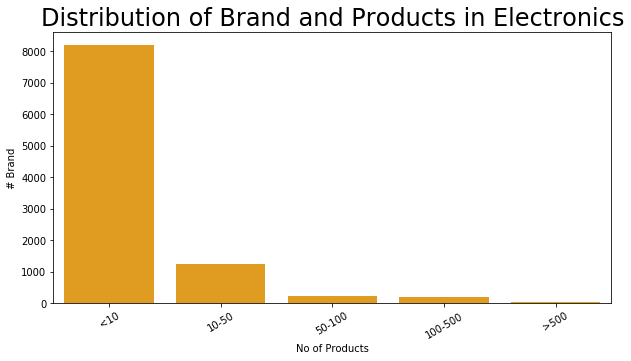

In [76]:
labels = ['<10','10-50','50-100','100-500','>500']

plt.figure(figsize=(10,5))
plt.title("Distribution of Brand and Products in Home&Kitchen",fontsize=24)
sns.barplot(x = BrandBucketRelation.bucket, y = BrandBucketRelation.NoofBrands,color='orange')
plt.xlabel('No of Products', fontsize=10)
plt.ylabel('# Brand', fontsize=10)
index = np.arange(len(BrandBucketRelation.bucket))
plt.xticks(index, labels, fontsize=10, rotation=30)

In [81]:
# Top 25 High Rated Brands with more than 100 products
sql = """
select brand Brand, COUNT(distinct asin) NoofProducts, COUNT(ReviewText) NoofReviews, ROUND(AVG(overall),2) AvgRating
from `reviewdata.review_home_kitchen`
where Brand is NOT NULL and Brand <> 'Unknown' and Brand <> ''
group by brand
having COUNT(distinct asin) > 100 AND AVG(overall) > 4
order by  COUNT(ReviewText) Desc,AVG(overall) DESC
LIMIT 25
"""
BrandHighRatingRelation100 = client.query(sql).to_dataframe()


In [82]:
BrandHighRatingRelation100

,Brand,NoofProducts,NoofReviews,AvgRating
0,Logitech,493,114553,4.18
1,Sony,2032,96104,4.09
2,SanDisk,616,79315,4.31
3,Canon,692,71328,4.39
4,Samsung,1068,61060,4.14
5,Garmin,531,54220,4.07
6,Apple,344,53165,4.24
7,Asus,704,46864,4.04
8,Panasonic,741,44689,4.21
9,Nikon,638,43265,4.33


In [83]:
# Top 25 High Rated Brands with more than 500 products
sql = """
select brand Brand, COUNT(distinct asin) NoofProducts, COUNT(ReviewText) NoofReviews, ROUND(AVG(overall),2) AvgRating
from `reviewdata.review_home_kitchen`
where Brand is NOT NULL and Brand <> 'Unknown' and Brand <> ''
group by brand
having COUNT(distinct asin) > 500 AND AVG(overall) > 4
order by  COUNT(ReviewText) Desc,AVG(overall) DESC
LIMIT 25
"""
BrandHighRatingRelation500 = client.query(sql).to_dataframe()

In [84]:
BrandHighRatingRelation = BrandHighRatingRelation500.head(10)

In [85]:
BrandHighRatingRelation

,Brand,NoofProducts,NoofReviews,AvgRating
0,Sony,2032,96104,4.09
1,SanDisk,616,79315,4.31
2,Canon,692,71328,4.39
3,Samsung,1068,61060,4.14
4,Garmin,531,54220,4.07
5,Asus,704,46864,4.04
6,Panasonic,741,44689,4.21
7,Nikon,638,43265,4.33
8,HP,2112,27728,4.01
9,StarTech,1161,20367,4.14


([<matplotlib.axis.XTick at 0x1b8de33b3c8>,
 <a list of 10 Text xticklabel objects>)

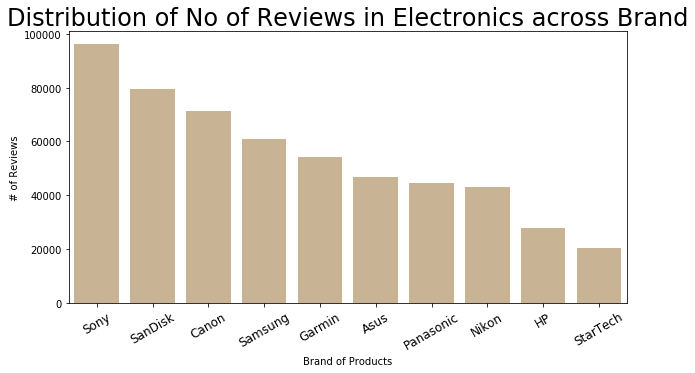

In [86]:
plt.figure(figsize=(10,5))
plt.title("Distribution of No of Reviews in Home&Kitchen across Brand",fontsize=24)
sns.barplot(x = BrandHighRatingRelation.Brand, y = BrandHighRatingRelation.NoofReviews,color='tan')
plt.xlabel('Brand of Products', fontsize=10)
plt.ylabel('# of Reviews', fontsize=10)
index = np.arange(len(BrandHighRatingRelation.Brand))
plt.xticks(index, BrandHighRatingRelation.Brand, fontsize=12, rotation=30)

([<matplotlib.axis.XTick at 0x1b8e81e6518>,
 <a list of 10 Text xticklabel objects>)

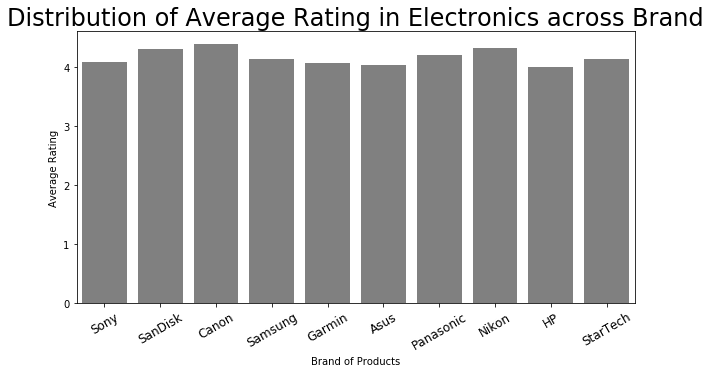

In [87]:
plt.figure(figsize=(10,5))
plt.title("Distribution of Average Rating in Home&Kitchen across Brand",fontsize=24)
sns.barplot(x = BrandHighRatingRelation.Brand, y = BrandHighRatingRelation.AvgRating,color='grey')
plt.xlabel('Brand of Products', fontsize=10)
plt.ylabel('Average Rating', fontsize=10)
index = np.arange(len(BrandHighRatingRelation.Brand))
plt.xticks(index, BrandHighRatingRelation.Brand, fontsize=12, rotation=30)

In [90]:
# Top 10 Low Rated Brands with more than 100 products
sql = """
select brand Brand, COUNT(distinct asin) NoofProducts, COUNT(ReviewText) NoofReviews, ROUND(AVG(overall),2) AvgRating
from `reviewdata.review_home_kitchen`
where Brand is NOT NULL and Brand <> 'Unknown' and Brand <> ''
group by brand
having COUNT(distinct asin) > 100 AND AVG(overall) < 2.5
order by  COUNT(ReviewText) Desc,AVG(overall) DESC
LIMIT 10
"""
BrandLowRatingRelation = client.query(sql).to_dataframe()
BrandLowRatingRelation

,Brand,NoofProducts,NoofReviews,AvgRating


In [91]:
# Top 10 Low Rated Brands
sql = """
select brand Brand, COUNT(distinct asin) NoofProducts, COUNT(ReviewText) NoofReviews,ROUND(AVG(overall),2) AvgRating
from `reviewdata.review_home_kitchen`
where Brand is NOT NULL and Brand <> 'Unknown' and Brand <> ''
group by brand
having AVG(overall) < 2
order by COUNT(distinct asin) desc, AVG(overall) ASC
LIMIT 10
"""
BrandLowRatingRelation = client.query(sql).to_dataframe()
BrandLowRatingRelation

,Brand,NoofProducts,NoofReviews,AvgRating
0,Mini Gadgets,14,40,1.95
1,Nextar,7,28,1.93
2,Hypercel,5,7,1.57
3,As Seen On TV,4,140,1.87
4,MGA,4,18,1.94
5,LensSkins,3,3,1.33
6,Hog Wild,3,5,1.60
7,Digital King,3,5,1.80
8,Paraben,3,20,1.95
9,T-Tech by Tumi,2,2,1.00


In [78]:
# Reviews from 2014
sql = """
select asin,ReviewText
from `reviewdata.review_home_kitchen`  
where reviewYear = 2014
"""
reviewData = client.query(sql).to_dataframe()

In [87]:
#Sentiment Analysis on Reviews
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
import re
from textblob import TextBlob
from stop_words import get_stop_words

def wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

In [44]:
def f_tags(review_df):
    if review_df['sentiment'] > 0:
        val = "Positive"
    elif review_df['sentiment'] == 0:
        val = "Neutral"
    else:
        val = "Negative"
    return val

In [88]:
#Process the Positive and Negative Reviews and Present the Frequency of words
def processWordCloud(review_df):
    text_lower = review_df['ReviewText'].str.lower().str.cat(sep=' ')
    # removes punctuation,numbers and returns list of words
    text_remove_pun = re.sub('[^A-Za-z]+', ' ', text_lower)
    #remove all the stopwords from the text
    stop_words = list(get_stop_words('en'))  
    nltk_words = list(stopwords.words('english'))
    nltk_words.extend(stop_words)
    
    word_tokens_tags = word_tokenize(text_remove_pun)
    filtered_sentence_tags = [w_tags for w_tags in word_tokens_tags if not w_tags in nltk_words]
    filtered_sentence_tags = []
    for w_tags in word_tokens_tags:
        if w_tags not in nltk_words:
            filtered_sentence_tags.append(w_tags)

    # Remove characters which have length less than 2  
    without_single_chr_tags = [word_tags for word_tags in filtered_sentence_tags if len(word_tags) > 2]

    # Remove numbers
    cleaned_data = [word_tags for word_tags in without_single_chr_tags if not word_tags.isnumeric()] 
    
    # Calculate frequency distribution
    word_dist = nltk.FreqDist(cleaned_data)
    rslt = pd.DataFrame(word_dist.most_common(100),
                        columns=['Word', 'Frequency'])

    plt.figure(figsize=(10,10))
    sns.set_style("whitegrid")
    ax = sns.barplot(x="Word", y="Frequency", data=rslt.head(7))
    
    wc(cleaned_data,'black','Frequent Words' )

In [79]:
# Calculate the Review Sentiment
reviewPolarity = []
for review in reviewData.ReviewText:
    blob = TextBlob(review)
    complete_sentiment = blob.sentiment.polarity
    sentence_polarity = []
    for sentence in blob.sentences:
        sentence_polarity.append(sentence.sentiment.polarity)
    reviewPolarity.append(round(sum(sentence_polarity),3))
reviewData['sentiment'] = reviewPolarity

In [80]:
#Tag the Review Sentiment Type
reviewData['Sentiment_Type'] = reviewData.apply(f_tags, axis=1)

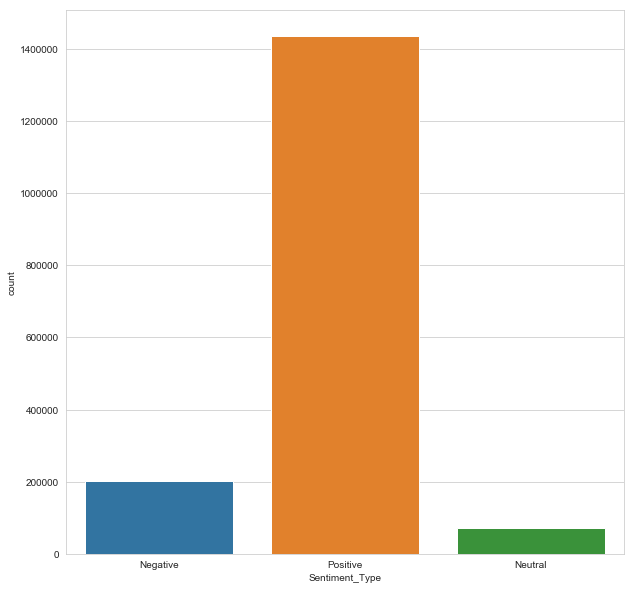

In [82]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=reviewData)

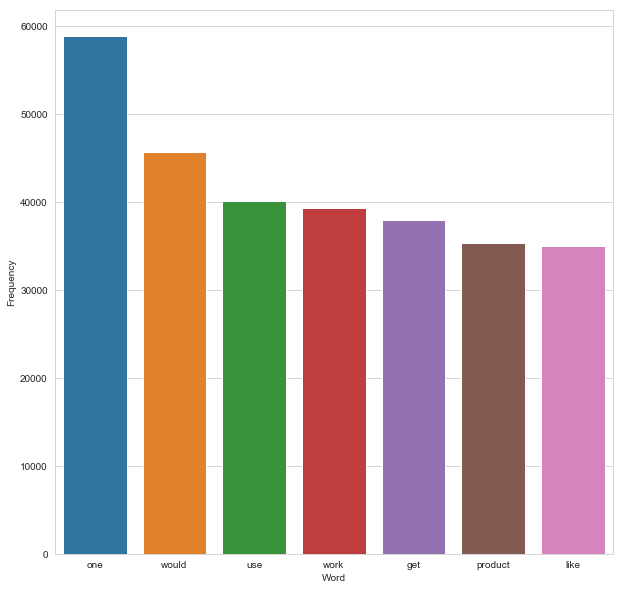

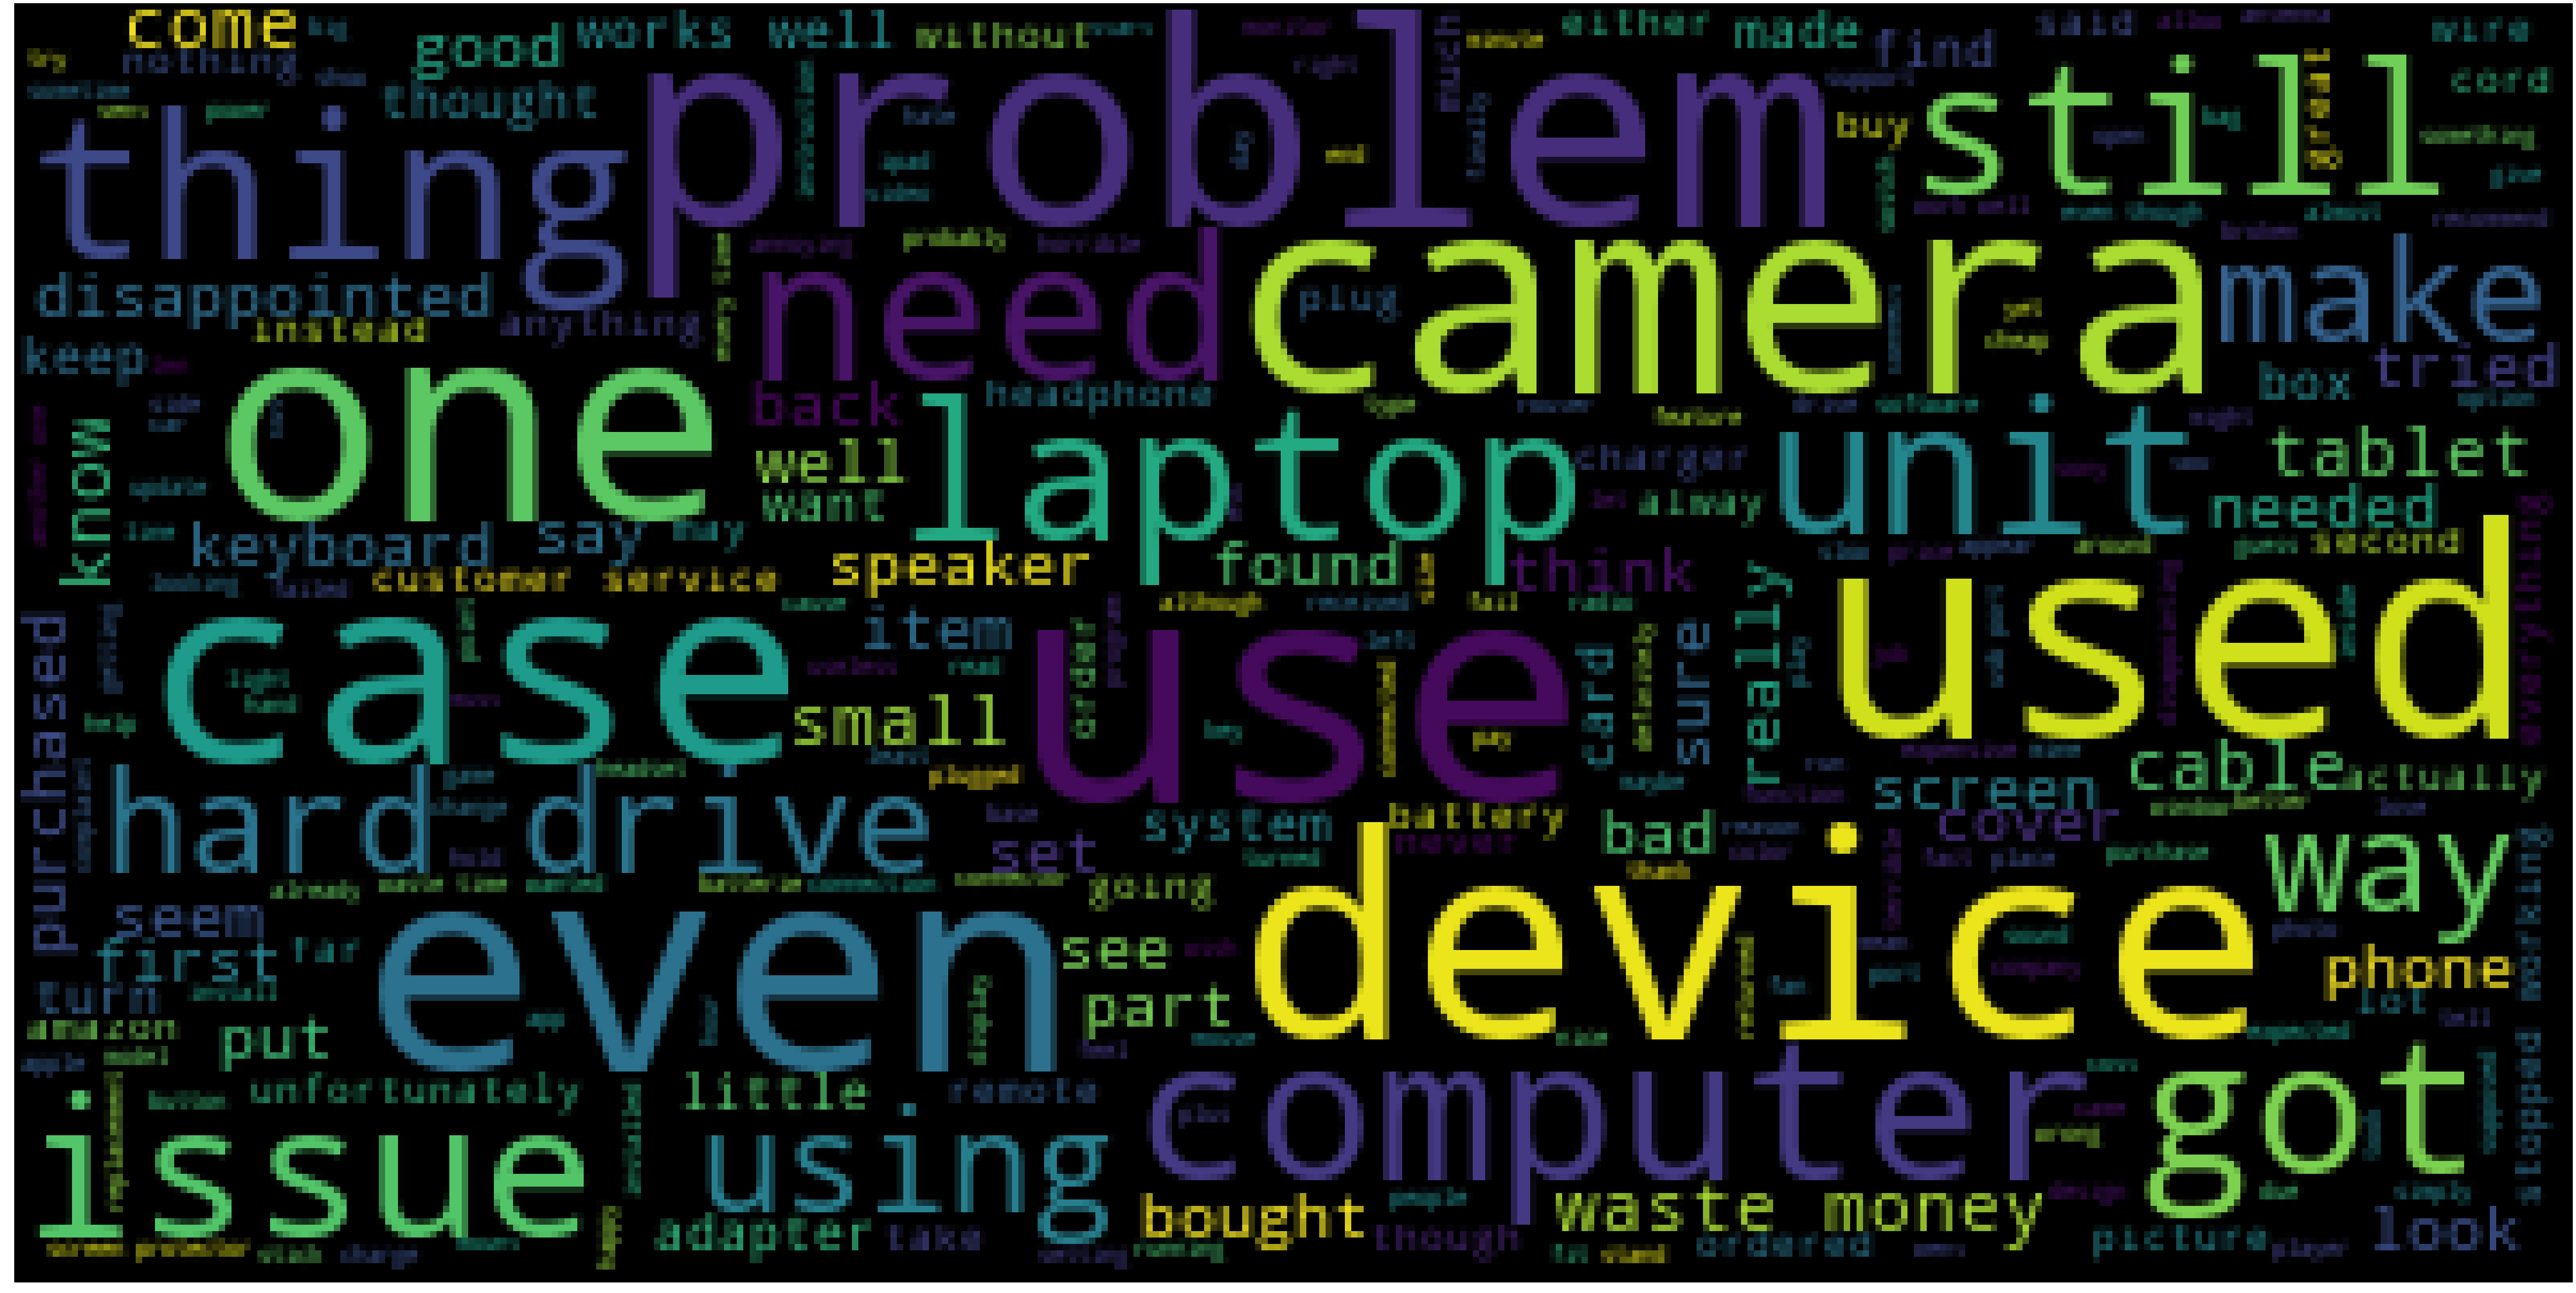

In [83]:
#Process Word Cloud and Frequency for Positive Sentiments
processWordCloud(reviewData[reviewData.Sentiment_Type == 'Negative'])